In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleAttenGRU(nn.Module):
    def __init__(self, classes):
        super(SimpleAttenGRU, self).__init__()
        self.feature_dim = 4
        self.hidden_dim = 6
        self.output_dim = classes
        self.num_layers = 2
        self.gru = nn.GRU(self.feature_dim, self.hidden_dim, self.num_layers, dropout=0.2)
        self.fc = nn.Linear(self.hidden_dim, classes)
        self.softmax = nn.Softmax(dim=1) 
        self.tanh = nn.Tanh()
        # atten parameter
        self.weight_proj = nn.Parameter(torch.Tensor(self.hidden_dim, 1))
        self.weight_W = nn.Parameter(torch.Tensor(self.hidden_dim, self.hidden_dim))
        self.bias = nn.Parameter(torch.Tensor(self.hidden_dim,1))
        self.weight_proj.data.uniform_(-0.1, 0.1)
        self.weight_W.data.data.uniform_(-0.1, 0.1)

    def batch_soft_atten(self, seq, W, bias, v):
        s = []
        batch_size = seq.shape[1]
        bias_dim = bias.size()
        for i in range(seq.size(0)):
            _s = torch.mm(seq[i], W)
            _s_bias = _s + bias.expand(bias_dim[0], batch_size).transpose(0,1)
            _s_bias = torch.tanh(_s_bias)
            _s = torch.mm(_s_bias, v)
            s.append(_s)
        s = torch.cat(s, dim=1)
        soft = self.softmax(s)
        return soft
    
    def attention_mul(self, rnn_outputs, att_weights):
        print(att_weights)
        print(rnn_outputs)
        attn_vectors = []
        for i in range(rnn_outputs.size(0)):
            h_i = rnn_outputs[i]
            a_i = att_weights[i].unsqueeze(1).expand_as(h_i)
            h_i = a_i * h_i
            h_i = h_i.unsqueeze(0)
            attn_vectors.append(h_i)
        attn_vectors = torch.cat(attn_vectors, dim=0)
        print(attn_vectors)
        return torch.sum(attn_vectors, 0)

    def soft_attention(self, ht):
        atten_alpha = self.batch_soft_atten(ht, self.weight_W, self.bias, self.weight_proj)
        atten_vects = self.attention_mul(ht, atten_alpha.transpose(0, 1))
        return atten_vects

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[2], x.shape[3])
        x = x.transpose(0, 1) # batch second
        self.gru.flatten_parameters()
        # self.hidden = self.init_hidden(x.shape[1])
        x, ht = self.gru(x)
        x = self.soft_attention(x)
        x = self.fc(x)
        return x, x

def test():
    data = torch.rand(2, 1, 3, 4)
    net = SimpleAttenGRU(4)
    result, _ = net(data)
    print(result)
    print(result.shape)
    
test()

tensor([[0.3336, 0.3336],
        [0.3333, 0.3334],
        [0.3331, 0.3330]], grad_fn=<TransposeBackward0>)
tensor([[[-0.0389,  0.0748,  0.2427, -0.0142, -0.0434,  0.1776],
         [-0.0644,  0.0985,  0.2304, -0.0214, -0.0396,  0.1564]],

        [[ 0.0618,  0.0183,  0.2834, -0.0287, -0.0695,  0.2872],
         [ 0.0153,  0.1182,  0.2851,  0.0334, -0.1488,  0.2090]],

        [[ 0.1490,  0.0006,  0.2879, -0.0357, -0.0890,  0.3538],
         [ 0.0657,  0.0694,  0.3803, -0.0044, -0.1232,  0.3366]]],
       grad_fn=<StackBackward>)
tensor([[[-0.0130,  0.0250,  0.0810, -0.0047, -0.0145,  0.0592],
         [-0.0215,  0.0329,  0.0768, -0.0071, -0.0132,  0.0522]],

        [[ 0.0206,  0.0061,  0.0945, -0.0096, -0.0231,  0.0957],
         [ 0.0051,  0.0394,  0.0950,  0.0111, -0.0496,  0.0697]],

        [[ 0.0496,  0.0002,  0.0959, -0.0119, -0.0297,  0.1178],
         [ 0.0219,  0.0231,  0.1266, -0.0015, -0.0410,  0.1121]]],
       grad_fn=<CatBackward>)
tensor([[-0.1510, -0.0324, -0.2105, -

In [22]:
h_i = torch.rand((3, 10))
a = torch.rand(3)
a.unsqueeze(1).expand_as(h_i)


tensor([[0.9046, 0.9046, 0.9046, 0.9046, 0.9046, 0.9046, 0.9046, 0.9046, 0.9046,
         0.9046],
        [0.2859, 0.2859, 0.2859, 0.2859, 0.2859, 0.2859, 0.2859, 0.2859, 0.2859,
         0.2859],
        [0.3921, 0.3921, 0.3921, 0.3921, 0.3921, 0.3921, 0.3921, 0.3921, 0.3921,
         0.3921]])

In [10]:
0.1450 * 0.8505 + 0.6774 * 0.9071

0.73779204

In [34]:
lstm = nn.LSTM(4, 8, 3, bidirectional=True, dropout=0.2, batch_first=True)
input = torch.randn(10, 3, 4)
output, (hn, cn) = lstm(input)
print(hn.shape)
print(output.shape)

torch.Size([6, 10, 8])
torch.Size([10, 3, 16])


In [ ]:
https://api.touhou.center/link/pgc82nOjmnCVowf1?mu=0

In [58]:
import librosa
import soundfile as sf
y1, s1 = librosa.load('/NASdata/AudioData/farfieldsvc20/data1_0/S0377/377MIC/S0377_377MIC_Tr4_0013_normal.wav', sr=16000)
y2, s2 = sf.read('/NASdata/AudioData/farfieldsvc20/data1_0/S0377/377MIC/S0377_377MIC_Tr4_0013_normal.wav')
y3, s3 = sf.read('/mingback/wuhw/new_code/hotword_mia/set1_full/temp.wav')
print(y1[100:110], s1)
print(y2[100:110], s2)
print(y3[100:110], s3)

sum(y1 - y3)

[ 1.6043212e-04 -3.0881882e-04 -1.3164947e-04  3.7886473e-04
 -1.0629969e-03 -1.2927054e-04 -8.8009183e-06  2.1792934e-04
  2.6774674e-04  4.2166191e-04] 16000
[-0.00201416 -0.00198364 -0.00177002 -0.00140381 -0.00097656 -0.00106812
 -0.00146484 -0.00140381 -0.00119019 -0.00094604] 48000
[ 1.22070312e-04 -2.74658203e-04 -1.83105469e-04  3.96728516e-04
 -1.06811523e-03 -9.15527344e-05 -6.10351562e-05  2.74658203e-04
  2.44140625e-04  4.57763672e-04] 16000


-0.00608997159596214

In [52]:
import numpy as np
np.array([1,2])-np.array([3,4])

array([-2, -2])

In [77]:
import torch
import numpy as np
import torch.nn as nn

seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


m = nn.AdaptiveAvgPool1d(1)

a = torch.rand(2,3,4)
print(a)
print(m(a))
print(a.mean(1))

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936]],

        [[0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317]]])
tensor([[[0.7849],
         [0.5104],
         [0.6505]],

        [[0.6519],
         [0.5883],
         [0.4599]]])
tensor([[0.7378, 0.5497, 0.5247, 0.7822],
        [0.6748, 0.5277, 0.4349, 0.6295]])


In [169]:
import python_speech_features as psf
import numpy as np

seed=42
np.random.seed(seed)

a = np.random.rand(1024 + 1024)
feat = psf.logfbank(a, 16000)

print(feat[4], )
print(feat[5])

[-4.93955074 -6.52471115 -6.1474677  -6.47977597 -5.63165226 -4.31584805
 -4.35876351 -4.14273914 -3.50394311 -3.05466163 -2.48976352 -2.0258619
 -1.52955206 -1.57884562 -1.5049025  -0.84848871 -0.99518019  0.16581019
  0.28213012  0.56030019  0.97564214  0.84956472  1.15563518  1.50326165
  1.53498143  1.64203316]
[-4.81124017 -6.09956452 -6.34379177 -5.64317338 -5.30244273 -4.3060827
 -3.89037145 -3.30734558 -2.89382744 -2.56346426 -2.33915007 -2.14876234
 -1.581807   -1.45751149 -1.23497027 -0.77835665 -0.68489126  0.00663928
  0.47352691  0.56563818  0.51418323  0.8035424   1.53860474  1.7074354
  1.46857081  1.86733401]


In [173]:
b = a[1024 - 384:2048]
feat = psf.logfbank(b, 16000)

print(feat.shape)
print(feat)

(8, 26)
[[-4.98175403e+00 -6.06505083e+00 -5.67174738e+00 -6.11272937e+00
  -5.16250513e+00 -4.04992347e+00 -4.44226366e+00 -4.14106094e+00
  -3.38071139e+00 -3.01323623e+00 -2.56080188e+00 -2.07839679e+00
  -1.51707965e+00 -1.62020009e+00 -1.55650648e+00 -8.39185077e-01
  -9.57506717e-01  1.72936835e-01  2.70355398e-01  5.70528816e-01
   9.74542858e-01  8.39284674e-01  1.14782291e+00  1.50756152e+00
   1.53530176e+00  1.64017815e+00]
 [-4.81124017e+00 -6.09956452e+00 -6.34379177e+00 -5.64317338e+00
  -5.30244273e+00 -4.30608270e+00 -3.89037145e+00 -3.30734558e+00
  -2.89382744e+00 -2.56346426e+00 -2.33915007e+00 -2.14876234e+00
  -1.58180700e+00 -1.45751149e+00 -1.23497027e+00 -7.78356651e-01
  -6.84891256e-01  6.63927728e-03  4.73526907e-01  5.65638175e-01
   5.14183235e-01  8.03542396e-01  1.53860474e+00  1.70743540e+00
   1.46857081e+00  1.86733401e+00]
 [-4.91368139e+00 -6.08296856e+00 -5.93096689e+00 -5.69963954e+00
  -5.59985820e+00 -3.83513195e+00 -4.04830164e+00 -3.50525823e+0

In [184]:
c = np.random.rand(720)
print(psf.logfbank(c, 16000))
print(psf.logfbank(c[320:], 16000))

[[-4.77910715 -5.46879802 -5.34576031 -5.26791882 -4.54709796 -4.96512749
  -4.17591987 -4.204888   -3.39106558 -2.93785614 -3.05222423 -2.46972068
  -1.92612542 -1.76183856 -1.49251159 -0.86357519 -0.47438309 -0.28621509
   0.14387222  0.8014804   0.93206971  1.39270625  1.18107353  1.42804694
   1.40156358  1.89118013]
 [-4.93143555 -6.26429507 -5.17895452 -5.00482973 -4.67812227 -5.05614044
  -4.54020211 -4.49377483 -3.20058672 -2.51452663 -2.41508459 -1.98553913
  -1.62526181 -1.91354478 -1.47264457 -0.97997278 -0.71918304 -0.21528469
  -0.03641704  0.79233259  1.01852533  1.17398467  1.06814919  1.0495659
   1.32057146  1.83585782]
 [-4.83790508 -6.15481286 -5.35652131 -5.40937509 -4.72557808 -4.22157644
  -4.24984886 -4.79734349 -4.00832909 -2.80883781 -2.4141242  -2.23253035
  -1.81837507 -2.23352592 -1.60491676 -0.38910135 -0.48411094 -0.3006112
   0.30020467  0.64288631  0.95623187  1.23031406  1.256851    1.06795645
   1.29900423  1.54045157]]
[[-4.75516887 -5.98586146 -5.199

In [181]:
# 1024 16000 5
# 2048 16000 12
import math
math.ceil(((16000 / 16000) - 0.015) / 0.01)
import numpy as np
np.concatenate([np.random.rand(1000), np.random.rand(2000)])[:-1].shape

240 - 160 - 160 - 160

480

In [148]:

rest_points = (1024 - (0.015 * 16000)) % (0.01 * 16000)
buf_sig_len = (0.015 * 16000) + rest_points
buf_sig_len


400.0

In [188]:
sig, sr = sf.read("/mingback/wuhw/data/hey_snips_research_6k_en_train_eval_clean_ter/audio_files/662a9628-9494-4722-bf1f-d70ad45e508b.wav")
psf.logfbank(sig, sr, nfilt=40).shape

(347, 40)

In [220]:
import numpy as np
S1 = np.random.rand(1000,1)
S2 = np.random.rand(1000,1) + 1

# cross-fade over last 200 elements
n = 200

W = np.linspace(200, 1, 200).reshape(200, 1)

# W.shape
S1[len(S1)-n:len(S1)] = W * S1[len(S1)-n:len(S1)]

S1[len(S1)-n:len(S1)].shape
W
# S2[1:n] = S2(1:n).*(1-W);

# S12 = zeros(size(S1,1) + size(S2,1) - n, 1);
# S12(1:size(S1,1)) = S1;
# S12(end-size(S1,1)+1:end) = S12(end-size(S1,1)+1:end) + S2;

array([[200.],
       [199.],
       [198.],
       [197.],
       [196.],
       [195.],
       [194.],
       [193.],
       [192.],
       [191.],
       [190.],
       [189.],
       [188.],
       [187.],
       [186.],
       [185.],
       [184.],
       [183.],
       [182.],
       [181.],
       [180.],
       [179.],
       [178.],
       [177.],
       [176.],
       [175.],
       [174.],
       [173.],
       [172.],
       [171.],
       [170.],
       [169.],
       [168.],
       [167.],
       [166.],
       [165.],
       [164.],
       [163.],
       [162.],
       [161.],
       [160.],
       [159.],
       [158.],
       [157.],
       [156.],
       [155.],
       [154.],
       [153.],
       [152.],
       [151.],
       [150.],
       [149.],
       [148.],
       [147.],
       [146.],
       [145.],
       [144.],
       [143.],
       [142.],
       [141.],
       [140.],
       [139.],
       [138.],
       [137.],
       [136.],
       [135.],
       [13

(190876,)


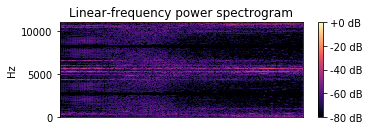

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt

y, sr = librosa.load('/mingback/wuhw/data/compare/data/train_0009.wav')
plt.figure(figsize=(12, 8))
print(y.shape)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

plt.show()